Import libraries

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, MaxPool2D, Dropout, Flatten, Conv2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from random import choice, shuffle
from scipy import stats as st

from collections import deque


collecting data

In [2]:
def gather_data(num_samples):

    global rock, paper, scissor, nothing

    # Initialize the camera
    cap = cv2.VideoCapture(0)

    # trigger tells us when to start recording
    trigger = False

    # Counter keeps count of the number of samples collected
    counter = 0

    # This the ROI size, the size of images saved will be box_size -10
    box_size = 234

    # Getting the width of the frame from the camera properties
    width = int(cap.get(3))

    while True:

        # Read frame by frame
        ret, frame = cap.read()

        # Flip the frame laterally
        frame = cv2.flip(frame, 1)

        # Break the loop if there is trouble reading the frame.
        if not ret:
            break

        # If counter is equal to the number samples then reset triger and the counter
        if counter == num_samples:
            trigger = not trigger
            counter = 0

        # Define ROI for capturing samples
        cv2.rectangle(frame, (width - box_size, 0),
                      (width, box_size), (0, 250, 150), 2)

        # Make a resizable window.
        cv2.namedWindow("Collecting images", cv2.WINDOW_NORMAL)

        # If trigger is True than start capturing the samples
        if trigger:

            # Grab only slected roi
            roi = frame[5: box_size-5, width-box_size + 5: width - 5]

            # Append the roi and class name to the list with the selected class_name
            eval(class_name).append([roi, class_name])

            # Increment the counter
            counter += 1

            # Text for the counter
            text = "Collected Samples of {}: {}".format(class_name, counter)

        else:
            text = "Press 'r' to collect rock samples, 'p' for paper, 's' for scissor and 'n' for nothing"

        # Show the counter on the imaege
        cv2.putText(frame, text, (3, 350), cv2.FONT_HERSHEY_SIMPLEX,
                    0.45, (0, 0, 255), 1, cv2.LINE_AA)

        # Display the window
        cv2.imshow("Collecting images", frame)

        # Wait 1 ms
        k = cv2.waitKey(1)

        # If user press 'r' than set the path for rock directoryq
        if k == ord('r'):

            # Trigger the variable inorder to capture the samples
            trigger = not trigger
            class_name = 'rock'
            rock = []

        # If user press 'p' then class_name is set to paper and trigger set to True
        if k == ord('p'):
            trigger = not trigger
            class_name = 'paper'
            paper = []

        # If user press 's' then class_name is set to scissor and trigger set to True
        if k == ord('s'):
            trigger = not trigger
            class_name = 'scissor'
            scissor = []

        # If user press 's' then class_name is set to nothing and trigger set to True
        if k == ord('n'):
            trigger = not trigger
            class_name = 'nothing'
            nothing = []

        # Exit if user presses 'q'
        if k == ord('q'):
            break

    #  Release the camera and destroy the window
    cap.release()
    cv2.destroyAllWindows()


In [3]:
no_of_samples = 150
gather_data(no_of_samples)

Visualize the data

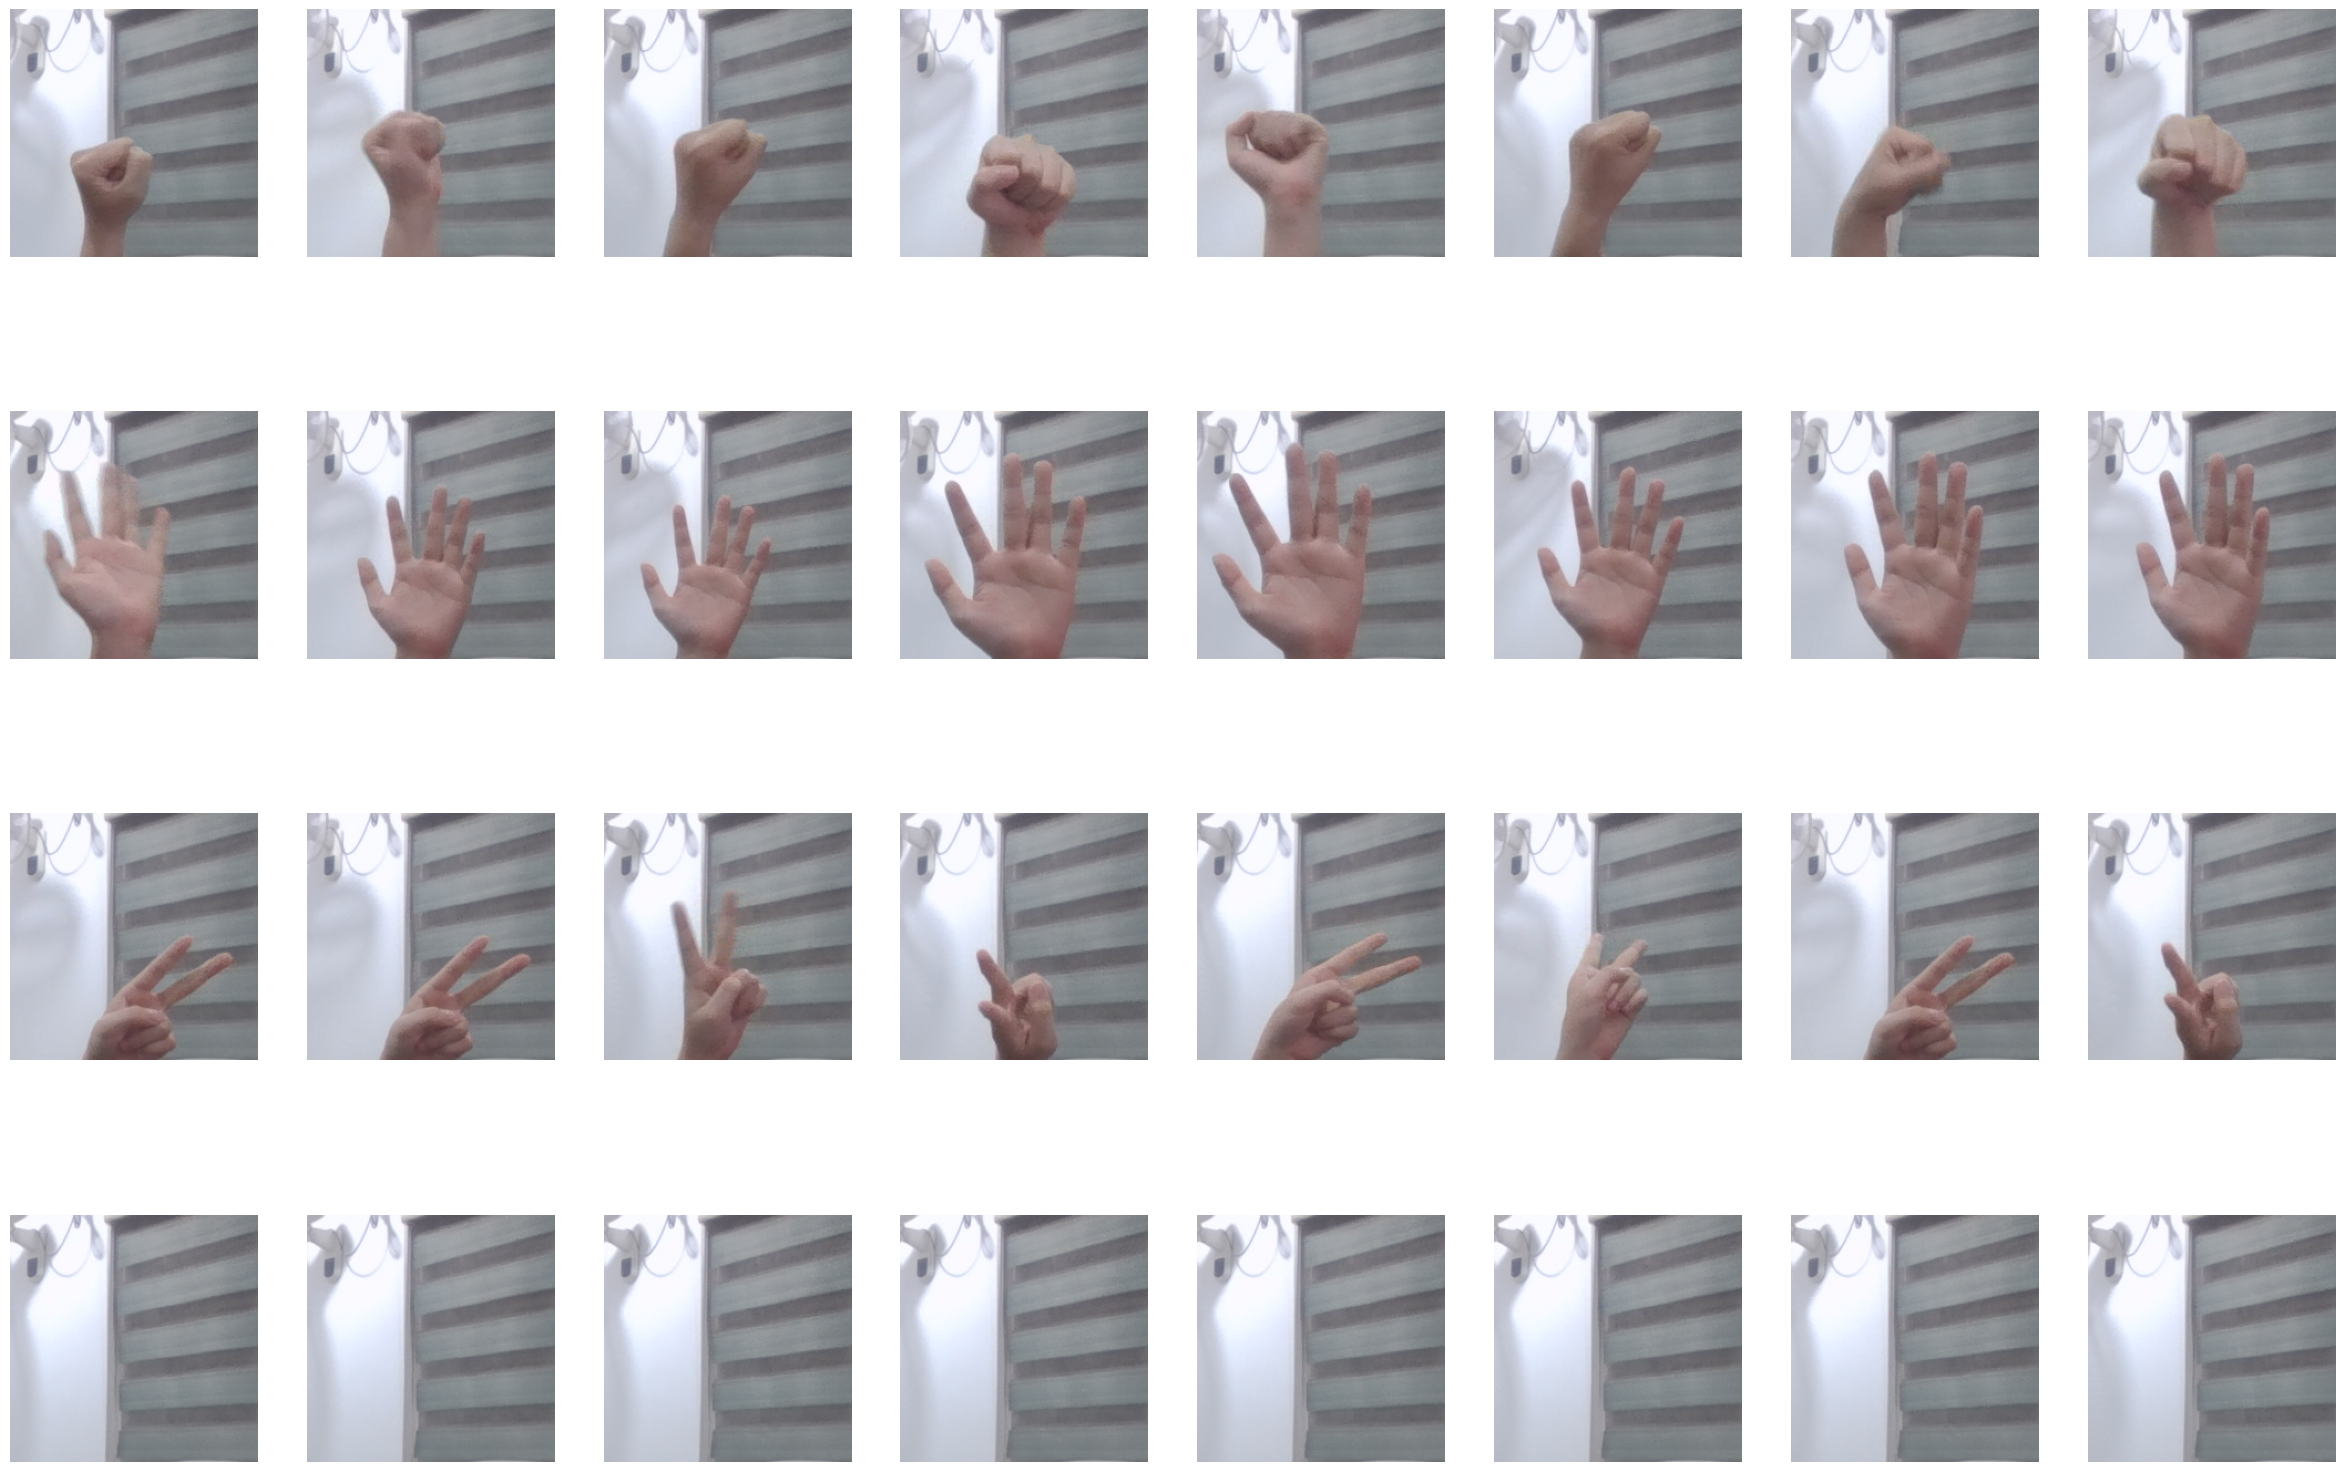

In [4]:
# Set the figure size
plt.figure(figsize=[30, 20])

# Set the rows and columns
rows, cols = 4, 8

# Iterate for each class
for class_index, each_list in enumerate([rock, paper, scissor, nothing]):

    # Get 8 random indexes, since we will be showing 8 examples of each class.
    r = np.random.randint(no_of_samples, size=8)

    # Plot the examples
    for i, example_index in enumerate(r, 1):
        plt.subplot(rows, cols, class_index*cols + i)
        plt.imshow(each_list[example_index][0][:, :, ::-1])
        plt.axis('off')


Preprocessing and splitting data

In [5]:
# Combine the labels of all classes together
labels = [tupl[1] for tupl in rock] + [tupl[1] for tupl in paper] + \
    [tupl[1] for tupl in scissor] + [tupl[1] for tupl in nothing]

# Combine the images of all classes together
images = [tupl[0] for tupl in rock] + [tupl[0] for tupl in paper] + \
    [tupl[0] for tupl in scissor] + [tupl[0] for tupl in nothing]

# Normalize the images by dividing by 255, now our images are in range 0-1. This will help in training.
images = np.array(images, dtype="float") / 255.0

# Print out the total number of labels and images.
print('Total images: {} , Total Labels: {}'.format(len(labels), len(images)))

# Create an encoder Object
encoder = LabelEncoder()

# Convert Lablels to integers. i.e. nothing = 0, paper = 1, rock = 2, scissor = 3 (mapping is done in alphabatical order)
Int_labels = encoder.fit_transform(labels)

# Now the convert the integer labels into one hot format. i.e. 0 = [1,0,0,0]  etc.
one_hot_labels = to_categorical(Int_labels, 4)

# Now we're splitting the data, 75% for training and 25% for testing.
(trainX, testX, trainY, testY) = train_test_split(
    images, one_hot_labels, test_size=0.25, random_state=50)

# Empty memory from RAM
images = []


# This can further free up memory from RAM but be careful, if you won't be able to change split % after this.
# rock, paper, scissor = [], [], []


Total images: 600 , Total Labels: 600


Prepare model 

In [6]:
# This is the input size which our model accepts.
image_size = 224
 
# Loading pre-trained NASNETMobile Model without the head by doing include_top = False
N_mobile = tf.keras.applications.NASNetMobile( input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
 
# Freeze the whole model 
N_mobile.trainable = False
     
# Adding our own custom head
# Start by taking the output feature maps from NASNETMobile
x = N_mobile.output
 
# Convert to a single-dimensional vector by Global Average Pooling. 
# We could also use Flatten()(x) GAP is more effective reduces params and controls overfitting.
x = GlobalAveragePooling2D()(x)
 
# Adding a dense layer with 712 units
x = Dense(712, activation='relu')(x) 
 
# Dropout 40% of the activations, helps reduces overfitting
x = Dropout(0.40)(x)
 
# The fianl layer will contain 4 output units (no of units = no of classes) with softmax function.
preds = Dense(4,activation='softmax')(x) 
 
# Construct the full model
model = Model(inputs=N_mobile.input, outputs=preds)
 
# Check the number of layers in the final Model
print ("Number of Layers in Model: {}".format(len(model.layers[:])))


Number of Layers in Model: 773


Train Model

In [7]:
# Adding transformations that I know would help, you can feel free to add more.
# I'm doing horizontal_flip = False, in case you aren't sure which hand you would be using you can make that True.
 
augment = ImageDataGenerator( 
     
        rotation_range=30,
        zoom_range=0.25,
        width_shift_range=0.10,
        height_shift_range=0.10,
        shear_range=0.10,
        horizontal_flip=False,
        fill_mode="nearest"
)

In [8]:
model.compile(optimizer=Adam(0.001), loss= 'categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Set batchsize according to your system
epochs = 15
batchsize = 20
 
# Start training
history = model.fit(x=augment.flow(trainX, trainY, batch_size=batchsize), validation_data=(testX, testY), 
steps_per_epoch= len(trainX) // batchsize, epochs=epochs)
 
# Use model.fit_generator function instead if TF version < 2.2
#history = model.fit_generator(x = augment.flow(trainX, trainY, batch_size=batchsize), validation_data=(testX, testY), 
#steps_per_epoch= len(trainX) // batchsize, epochs=epochs)

Epoch 1/15
22/22 [==============================] - 28s 836ms/step - loss: 0.7670 - accuracy: 0.7000 - val_loss: 0.3202 - val_accuracy: 0.8867
Epoch 2/15
22/22 [==============================] - 14s 654ms/step - loss: 0.2657 - accuracy: 0.8837 - val_loss: 0.1270 - val_accuracy: 0.9467
Epoch 3/15
22/22 [==============================] - 13s 611ms/step - loss: 0.1555 - accuracy: 0.9512 - val_loss: 0.0701 - val_accuracy: 0.9733
Epoch 4/15
22/22 [==============================] - 14s 625ms/step - loss: 0.1231 - accuracy: 0.9558 - val_loss: 0.0289 - val_accuracy: 1.0000
Epoch 5/15
22/22 [==============================] - 14s 619ms/step - loss: 0.1003 - accuracy: 0.9651 - val_loss: 0.0324 - val_accuracy: 0.9933
Epoch 6/15
22/22 [==============================] - 14s 617ms/step - loss: 0.0660 - accuracy: 0.9814 - val_loss: 0.0318 - val_accuracy: 0.9933
Epoch 7/15
22/22 [==============================] - 14s 625ms/step - loss: 0.0765 - accuracy: 0.9698 - val_loss: 0.0261 - val_accuracy: 0.9933

Check accuracy

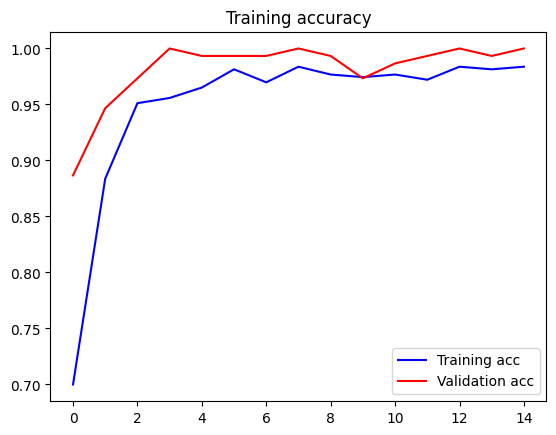

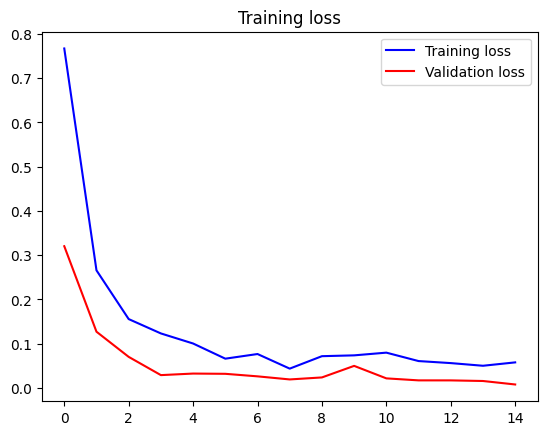

In [10]:
# Plot the accuracy and loss curves
 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.legend()
 
plt.show()

Save and Load model

In [11]:
model.save("rps4.h5")


In [3]:
model = load_model("rps4.h5")


Testing model accuracy

In [4]:
# This list will be used to map probabilities to class names, Label names are in alphabetical order.
label_names = ['nothing', 'paper', 'rock', 'scissor']
 
cap = cv2.VideoCapture(0)
box_size = 234
width = int(cap.get(3))
 
while True:
     
    ret, frame = cap.read()
    if not ret:
        break
         
    frame = cv2.flip(frame, 1)
            
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
         
    cv2.namedWindow("Rock Paper Scissors", cv2.WINDOW_NORMAL)
 
    roi = frame[5: box_size-5 , width-box_size + 5: width -5]
     
    # Normalize the image like we did in the preprocessing step, also convert float64 array.
    roi = np.array([roi]).astype('float64') / 255.0
  
    # Get model's prediction.
    pred = model.predict(roi)
     
    # Get the index of the target class.
    target_index = np.argmax(pred[0])
 
    # Get the probability of the target class
    prob = np.max(pred[0])
 
    # Show results
    cv2.putText(frame, "prediction: {} {:.2f}%".format(label_names[np.argmax(pred[0])], prob*100 ),
                (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 0, 255), 2, cv2.LINE_AA)
     
    cv2.imshow("Rock Paper Scissors", frame)
     
    
    k = cv2.waitKey(1)
    if k == ord('q'):
        break
 
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 48ms/step


Define ref :v

In [5]:
def findout_winner(user_move, Computer_move):
     
    # All logic below is self explanatory 
     
    if user_move == Computer_move:
        return "Tie"   
     
    elif user_move == "rock" and Computer_move == "scissor":
        return "User"
     
    elif user_move == "rock" and Computer_move == "paper":
        return "Computer"
     
    elif user_move == "scissor" and Computer_move == "rock":
        return "Computer"
     
    elif user_move == "scissor" and Computer_move == "paper":
        return "User"
     
    elif user_move == "paper" and Computer_move == "rock":
        return "User"
     
    elif user_move == "paper" and Computer_move == "scissor":
        return "Computer"

In [6]:
user_move = 'paper'
computer_move = choice(['rock', 'paper', 'scissor'])
 
winner = findout_winner(user_move, computer_move)
 
print("User Selected '{}' and computer selected '{}' , winner is: '{}' ".format(user_move, computer_move, winner))

User Selected 'paper' and computer selected 'scissor' , winner is: 'Computer' 


In [7]:
user_move = 'paper'
computer_move = choice(['rock', 'paper', 'scissor'])
 
winner = findout_winner(user_move, computer_move)
 
print("User Selected '{}' and computer selected '{}' , winner is: '{}' ".format(user_move, computer_move, winner))


User Selected 'paper' and computer selected 'paper' , winner is: 'Tie' 


In [8]:
def show_winner(user_socre, computer_score):    
     
    if user_score > computer_score:
        img = cv2.imread("download.png")
         
    elif user_score < computer_score:
        img = cv2.imread("comwins.png")
         
    else:
        img = cv2.imread("draw.jpg")
         
    cv2.putText(img, "Press 'ENTER' to play again, else exit",
                (150, 530), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 3, cv2.LINE_AA)
     
    cv2.imshow("Rock Paper Scissors", img)
     
    # If enter is pressed.
    k = cv2.waitKey(0)
     
    # If the user presses 'ENTER' key then return TRUE, otherwise FALSE
    if k == 13:
       return True
 
    else:
        return False

In [9]:
def display_computer_move(computer_move_name, frame):
     
    icon = cv2.imread( "{}.jpg".format(computer_move_name), 1)
    icon = cv2.resize(icon, (224,224))
     
    # This is the portion which we are going to replace with the icon image
    roi = frame[0:224, 0:224]
 
    # Get binary mask from the transparent image, 4th channel is the alpha channel 
    mask = icon[:,:,-1] 
 
    # Making the mask completely binary (black & white)
    mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)[1]
 
    # Store the normal bgr image
    icon_bgr = icon[:,:,:3] 
     
    # Now combine the foreground of the icon with background of ROI 
     
    img1_bg = cv2.bitwise_and(roi, roi, mask = cv2.bitwise_not(mask))
 
    img2_fg = cv2.bitwise_and(icon_bgr, icon_bgr, mask = mask)
 
    combined = cv2.add(img1_bg, img2_fg)
 
    frame[0:224, 0:224] = combined
 
    return frame

Final application

In [10]:
cap = cv2.VideoCapture(0)
box_size = 234
width = int(cap.get(3))
 
# Specify the number of attempts you want. This means best of 5.
attempts = 5
 
# Initially the moves will be `nothing`
computer_move_name= "nothing"
final_user_move = "nothing"
 
label_names = ['nothing', 'paper', 'rock', 'scissor']
 
# All scores are 0 at the start.
computer_score, user_score = 0, 0
 
# The default color of bounding box is Blue
rect_color = (255, 0, 0)
 
# This variable remembers if the hand is inside the box or not.
hand_inside = False
 
# At each iteration we will decrease the total_attempts value by 1
total_attempts = attempts
 
# We will only consider predictions having confidence above this threshold.
confidence_threshold = 0.70
 
# Instead of working on a single prediction, we will take the mode of 5 predictions by using a deque object
# This way even if we face a false positive, we would easily ignore it
smooth_factor = 5
 
# Our initial deque list will have 'nothing' repeated 5 times.
de = deque(['nothing'] * 5, maxlen=smooth_factor)
 
while True:
     
    ret, frame = cap.read()
     
    if not ret:
        break
         
    frame = cv2.flip(frame, 1)
            
    cv2.namedWindow("Rock Paper Scissors", cv2.WINDOW_NORMAL)
 
    # extract the region of image within the user rectangle
    roi = frame[5: box_size-5 , width-box_size + 5: width -5]
     
    roi = np.array([roi]).astype('float64') / 255.0
     
    # Predict the move made
    pred = model.predict(roi)
     
    # Get the index of the predicted class
    move_code = np.argmax(pred[0])
    
    # Get the class name of the predicted class
    user_move = label_names[move_code]
     
    # Get the confidence of the predicted class
    prob = np.max(pred[0])
     
    # Make sure the probability is above our defined threshold
    if prob >= confidence_threshold:
         
        # Now add the move to deque list from left
        de.appendleft(user_move)
         
        # Get the mode i.e. which class has occured more frequently in the last 5 moves.
        try:
            final_user_move = st.mode(de)[0][0] 
             
        except StatisticsError:
            print('Stats error')
            continue
              
        # If nothing is not true and hand_inside is False then proceed.
        # Basically the hand_inside variable is helping us to not repeatedly predict during the loop
        # So now the user has to take his hands out of the box for every new prediction.
         
        if final_user_move != "nothing" and hand_inside == False:
             
            # Set hand inside to True
            hand_inside = True
             
            # Get Computer's move and then get the winner.
            computer_move_name = choice(['rock', 'paper', 'scissor'])
            winner = findout_winner(final_user_move, computer_move_name)
             
            # Display the computer's move
            display_computer_move(computer_move_name, frame)
             
            # Subtract one attempt
            total_attempts -= 1
             
            # If winner is computer then it gets points and vice versa.
            # We're also changing the color of rectangle based on who wins the round.
 
            if winner == "Computer":
                computer_score +=1
                rect_color = (0, 0, 255)
 
            elif winner == "User":
                user_score += 1;
                rect_color = (0, 250, 0)                
             
            elif winner == "Tie":
                rect_color = (255, 250, 255)
                 
                 
            # If all the attempts are up then find our the winner      
            if total_attempts == 0:
                 
                play_again = show_winner(user_score, computer_score)
                 
                # If the user pressed Enter then restart the game by re initializing all variables
                if play_again:
                    user_score, computer_score, total_attempts = 0, 0, attempts
                 
                # Otherwise quit the program.
                else:
                    break
         
        # Display images when the hand is inside the box even when hand_inside variable is True.
        elif final_user_move != "nothing" and hand_inside == True:
            display_computer_move(computer_move_name, frame)
     
        # If class is nothing then hand_inside becomes False
        elif final_user_move == 'nothing':            
            hand_inside = False
            rect_color = (255, 0, 0) 
 
    # This is where all annotation is happening. 
 
    cv2.putText(frame, "Your Move: " + final_user_move,
                    (420, 270), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
 
    cv2.putText(frame, "Computer's Move: " + computer_move_name,
                (2, 270), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
 
    cv2.putText(frame, "Your Score: " + str(user_score),
                    (420, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(frame, "Computer Score: " + str(computer_score),
                    (2, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
     
    cv2.putText(frame, "Attempts left: {}".format(total_attempts), (190, 400), cv2.FONT_HERSHEY_COMPLEX, 0.7,
                (100, 2, 255), 1, cv2.LINE_AA)    
     
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), rect_color, 2)
 
    # Display the image    
    cv2.imshow("Rock Paper Scissors", frame)
 
    # Exit if 'q' is pressed 
    k = cv2.waitKey(10)
    if k == ord('q'):
        break
 
# Relase the camera and destroy all windows.
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 45ms/step


C:\Users\hoang\AppData\Local\Temp\ipykernel_23028\469397369.py:72: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_user_move = st.mode(de)[0][0]
C:\Users\hoang\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
C:\Users\hoang\AppData\Local\Temp\ipykernel_23028\469397369.py:72: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used inste

1/1 [==============================] - 0s 41ms/step
